<h1><center>Anomaly Detection with Isolation Forest</center></h1>

<h2>Importing essential modules</h2>

In [84]:
"""Initialization for Jupyter Notebook"""
import sys 
import os 
import entity_id as eid
import pandas as pd
from msticpy.nbtools import *
import category_encoders as ce
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import IsolationForest
import xlsxwriter   
import numpy as np
from IPython.display import display
import ipywidgets 
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
import squarify
import matplotlib.widgets as mpwidgets

<h2>Notebook setup</h2>

In [2]:
nbinit.init_notebook(namespace=globals());
# Load query providers
qry_prov = QueryProvider("AzureSentinel")

Please wait. Loading Kqlmagic extension...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
qry_prov.connect(WorkspaceConfig())

<IPython.core.display.Javascript object>

<h2>Obtaining and understanding the data</h2>
<p>Here the user is selecting a table, an entity, and other features (columns), and the time range. The entities can be easily derived by using the Entity Identification feature of ASDET</p>

In [4]:
tables = qry_prov.schema_tables

In [5]:
print("Please select a single table you would like to analyze")
#Selecting a table from the Azure Sentinel schema through ipywidget (default is OfficeActivity)
dropdown = ipywidgets.Dropdown(
    options=sorted(tables),
    value='OfficeActivity',
    description='Tables',
)
display(dropdown)

Please select a single table you would like to analyze


Dropdown(description='Tables', index=234, options=('AACAudit', 'AACHttpRequest', 'AADDomainServicesAccountLogo…

In [6]:
#defining the table
table = dropdown.value 
#using the entity_id module to get entites for our selected table
query = eid.EntityIdentifier(qry_prov)

In [7]:
#Raw data before feature engineering
raw_data = qry_prov.exec_query(table)

In [8]:
raw_data.head()

,TenantId,Application,UserDomain,UserAgent,RecordType,TimeGenerated,Operation,OrganizationId,OrganizationId_,UserType,UserKey,OfficeWorkload,ResultStatus,ResultReasonType,OfficeObjectId,UserId,UserId_,ClientIP,ClientIP_,Scope,Site_,ItemType,EventSource,Source_Name,MachineDomainInfo,...,ChannelType,ChannelName,ChannelGuid,ExtraProperties,AddOnType,AddonName,TabType,Name,OldValue,NewValue,ItemName,ChatThreadId,ChatName,CommunicationType,AADGroupId,AddOnGuid,AppDistributionMode,TargetUserId,OperationScope,AzureADAppId,OperationProperties,AppId,ClientAppId,Type,_ResourceId
0,8ecf8077-cf51-4820-aadd-14040956f35d,,,,ExchangeItem,2021-08-10 11:55:18+00:00,Send,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,10032001582C649E,Exchange,Succeeded,Succeeded,,sbeavers@seccxp.ninja,sbeavers@seccxp.ninja,20.190.142.170,20.190.142.170,,,,,,,...,,,,None,,,,,,,,,,,,,,,,,None,00000003-0000-0000-c000-000000000000,0d465159-840f-4192-a055-3e9141695cb9,OfficeActivity,
1,8ecf8077-cf51-4820-aadd-14040956f35d,,,,50,2021-08-10 11:56:29+00:00,MailItemsAccessed,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,10032001582C649E,Exchange,Succeeded,Succeeded,,sbeavers@seccxp.ninja,sbeavers@seccxp.ninja,,,,,,,,,...,,,,None,,,,,,,,,,,,,,,,,"[{'Value': 'Bind', 'Name': 'MailAccessType'}, {'Value': 'False', 'Name': 'IsThrottled'}]",00000002-0000-0ff1-ce00-000000000000,,OfficeActivity,
2,8ecf8077-cf51-4820-aadd-14040956f35d,,,,ExchangeItem,2021-08-10 11:33:52+00:00,Update,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,1003200160C8B403,Exchange,Succeeded,Succeeded,,KDickens@seccxp.ninja,KDickens@seccxp.ninja,20.185.147.197,20.185.147.197,,,,,,,...,,,,None,,,,,,,,,,,,,,,,,None,,,OfficeActivity,
3,8ecf8077-cf51-4820-aadd-14040956f35d,,,,ExchangeItem,2021-08-10 11:33:31+00:00,Send,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,1003200160C8B403,Exchange,Succeeded,Succeeded,,KDickens@seccxp.ninja,KDickens@seccxp.ninja,20.190.142.169,20.190.142.169,,,,,,,...,,,,None,,,,,,,,,,,,,,,,,None,00000003-0000-0000-c000-000000000000,0d465159-840f-4192-a055-3e9141695cb9,OfficeActivity,
4,8ecf8077-cf51-4820-aadd-14040956f35d,,,,ExchangeItem,2021-08-10 12:36:16+00:00,Send,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,10032001582E7CD0,Exchange,Succeeded,Succeeded,,nmartha@seccxp.ninja,nmartha@seccxp.ninja,20.190.142.170,20.190.142.170,,,,,,,...,,,,None,,,,,,,,,,,,,,,,,None,00000003-0000-0000-c000-000000000000,0d465159-840f-4192-a055-3e9141695cb9,OfficeActivity,


In [9]:
raw_data.shape

(28820, 131)

<h2>Feature Engineering</h2>
<p>In this section we clean our raw data and make it ready to be used in the modeling through grouping by our data based on entities and features and encoding it</p>

In [10]:
def clean_extra_columns(df):
    """
    Cleans all extra columns of the table. Removes any identical columns with each and every datapoint being same for example URL and URL_ which have the exact same data just different column names
    
    Parameters
    -------
    
    df - takes in a dataframe type object
    
    Returns
    -------
    
    a new dataframe type object with no redundant column
    """

    #exit if dataframe is empty
    if df.empty == True:
        print("The dataframe has no data")
        return 
    #creating a list of the columns to parse
    cols_list = list(df.columns)
    #working on a copy of the list to retain the original list
    df_columns_copy = (cols_list).copy()
    #Two pointer method that checks if two columns are exactly the same in terms of data 
    #If yes, removes the column. If no, retains it. Pointer one iterates over first list of column
    #and compares with every column in the second list 
    #The pointers also keep track of not comparing a column to itself. 
    #pointer one
    cols_p = 0
    #pointer two
    colscopy_p = 0  
    #columns that have been checked and are not redundant
    seen = [] 
    #columns that have been checked and are redundant
    to_delete = []
    while cols_p < len(cols_list):
        #if each data point is same and columns pointer - hence names - are not equal and the column has not already been checked before
        if df[cols_list[cols_p]].equals(df[cols_list[colscopy_p]]) and (cols_p != colscopy_p) and (cols_list[cols_p] not in seen): #if equates to True
            #Add it to seen 
            seen.append(cols_list[colscopy_p])
            #And add it to delete since it is redundant 
            to_delete.append(cols_list[colscopy_p])
            #increase pointer 
            if colscopy_p == len(cols_list)-1:
                cols_p+=1
                colscopy_p = 0
            else:
                colscopy_p+=1
        #if a column in the first list has been checked with every other column in the second list
        #move to the next column to check in the first list       
        elif colscopy_p == len(cols_list)-1:
            cols_p+=1
            colscopy_p = 0
        #move to the next column in the second list
        else:
            colscopy_p+=1
    #drop all redundant columns     
    df.drop(columns = to_delete, axis=1, inplace= True)
    return df           

In [11]:
clean_extra_columns(raw_data)

,TenantId,Application,UserAgent,RecordType,TimeGenerated,Operation,OrganizationId,UserType,UserKey,OfficeWorkload,ResultStatus,OfficeObjectId,UserId,ClientIP,Site_,ItemType,EventSource,Site_Url,SourceRelativeUrl,SourceFileName,SourceFileExtension,DestinationRelativeUrl,DestinationFileName,DestinationFileExtension,Event_Data,...,Folders,AffectedItems,Item,ModifiedProperties,LoginStatus,ElevationTime,ElevationApprovedTime,SourceSystem,OfficeId,OfficeTenantId,TargetUserOrGroupName,TargetUserOrGroupType,MessageId,Members,TeamName,TeamGuid,ExtraProperties,ItemName,ChatThreadId,CommunicationType,AADGroupId,OperationProperties,AppId,ClientAppId,Type
0,8ecf8077-cf51-4820-aadd-14040956f35d,,,ExchangeItem,2021-08-10 11:55:18+00:00,Send,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,10032001582C649E,Exchange,Succeeded,,sbeavers@seccxp.ninja,20.190.142.170,,,,,,,,,,,,...,,,"{""Id"":""Unknown"",""InternetMessageId"":""<SJ0P221MB069137C0B5F4B83693C2DB1AAFF79@SJ0P221MB0691.NAMP2...",,NaN,2021-08-10 12:05:23+00:00,NaT,OfficeActivityManager,7ed7cbc8-8060-460f-8519-08d95bf5b931,$RestApiTenantId$,,,,None,,,None,,,,,None,00000003-0000-0000-c000-000000000000,0d465159-840f-4192-a055-3e9141695cb9,OfficeActivity
1,8ecf8077-cf51-4820-aadd-14040956f35d,,,50,2021-08-10 11:56:29+00:00,MailItemsAccessed,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,10032001582C649E,Exchange,Succeeded,,sbeavers@seccxp.ninja,,,,,,,,,,,,,...,"[{""FolderItems"":[{""InternetMessageId"":""<AM6PR01MB60714C5726524A7158CE84B1A8F79@AM6PR01MB6071.eur...",,,,NaN,2021-08-10 12:05:23+00:00,NaT,OfficeActivityManager,3e13965d-3cd1-44c0-8005-7548302ae722,$RestApiTenantId$,,,,None,,,None,,,,,"[{'Value': 'Bind', 'Name': 'MailAccessType'}, {'Value': 'False', 'Name': 'IsThrottled'}]",00000002-0000-0ff1-ce00-000000000000,,OfficeActivity
2,8ecf8077-cf51-4820-aadd-14040956f35d,,,ExchangeItem,2021-08-10 11:33:52+00:00,Update,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,1003200160C8B403,Exchange,Succeeded,,KDickens@seccxp.ninja,20.185.147.197,,,,,,,,,,,,...,,,"{""Attachments"":"" (3127b)"",""Id"":""RgAAAAB/23qB4U26RbtEZaWzb8igBwBv9IbCbPDrS7XLRiGhjWK1AAAAAAEMAABv...","[""RecipientCollection"",""AllAttachmentsHidden""]",NaN,2021-08-10 11:40:26+00:00,NaT,OfficeActivityManager,9c12a625-5c57-41bc-2983-08d95bf2bae3,$RestApiTenantId$,,,,None,,,None,,,,,None,,,OfficeActivity
3,8ecf8077-cf51-4820-aadd-14040956f35d,,,ExchangeItem,2021-08-10 11:33:31+00:00,Send,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,1003200160C8B403,Exchange,Succeeded,,KDickens@seccxp.ninja,20.190.142.169,,,,,,,,,,,,...,,,"{""Id"":""Unknown"",""InternetMessageId"":""<BL3P221MB0387C392181935AC1A3F9A3EBEF79@BL3P221MB0387.NAMP2...",,NaN,2021-08-10 11:40:26+00:00,NaT,OfficeActivityManager,67b7a9a3-e7dd-4b6b-5c88-08d95bf2ae18,$RestApiTenantId$,,,,None,,,None,,,,,None,00000003-0000-0000-c000-000000000000,0d465159-840f-4192-a055-3e9141695cb9,OfficeActivity
4,8ecf8077-cf51-4820-aadd-14040956f35d,,,ExchangeItem,2021-08-10 12:36:16+00:00,Send,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,10032001582E7CD0,Exchange,Succeeded,,nmartha@seccxp.ninja,20.190.142.170,,,,,,,,,,,,...,,,"{""Id"":""Unknown"",""InternetMessageId"":""<CH0P221MB03800D3ECA50EED0DC213850C5F79@CH0P221MB0380.NAMP2...",,NaN,2021-08-10 12:45:27+00:00,NaT,OfficeActivityManager,e0d760dd-88f3-4550-a5e8-08d95bfb7262,$RestApiTenantId$,,,,None,,,None,,,,,None,00000003-0000-0000-c000-000000000000,0d465159-840f-4192-a055-3e9141695cb9,OfficeActivity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28815,8ecf8077-cf51-4820-aadd-14040956f35d,,,ExchangeItemGroup,2021-07-16 10:15:18+00:00,MoveToDeletedItems,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,10032001582C649E,Exchange,Succeeded,,sbeavers@seccxp.ninja,95.40.88.238,,,,,,,,,,,,...,,"[\r\n {\r\n ""Attachments"": "" (3022b)"",\r\n ""Id"": ""RgAAAAAR5F8vzsGtSp4cbACUG3kPBwCxa+nLWlo...",,,NaN

In [12]:
raw_data.head()

,TenantId,Application,UserAgent,RecordType,TimeGenerated,Operation,OrganizationId,UserType,UserKey,OfficeWorkload,ResultStatus,OfficeObjectId,UserId,ClientIP,Site_,ItemType,EventSource,Site_Url,SourceRelativeUrl,SourceFileName,SourceFileExtension,DestinationRelativeUrl,DestinationFileName,DestinationFileExtension,Event_Data,...,Folders,AffectedItems,Item,ModifiedProperties,LoginStatus,ElevationTime,ElevationApprovedTime,SourceSystem,OfficeId,OfficeTenantId,TargetUserOrGroupName,TargetUserOrGroupType,MessageId,Members,TeamName,TeamGuid,ExtraProperties,ItemName,ChatThreadId,CommunicationType,AADGroupId,OperationProperties,AppId,ClientAppId,Type
0,8ecf8077-cf51-4820-aadd-14040956f35d,,,ExchangeItem,2021-08-10 11:55:18+00:00,Send,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,10032001582C649E,Exchange,Succeeded,,sbeavers@seccxp.ninja,20.190.142.170,,,,,,,,,,,,...,,,"{""Id"":""Unknown"",""InternetMessageId"":""<SJ0P221MB069137C0B5F4B83693C2DB1AAFF79@SJ0P221MB0691.NAMP2...",,NaN,2021-08-10 12:05:23+00:00,NaT,OfficeActivityManager,7ed7cbc8-8060-460f-8519-08d95bf5b931,$RestApiTenantId$,,,,None,,,None,,,,,None,00000003-0000-0000-c000-000000000000,0d465159-840f-4192-a055-3e9141695cb9,OfficeActivity
1,8ecf8077-cf51-4820-aadd-14040956f35d,,,50,2021-08-10 11:56:29+00:00,MailItemsAccessed,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,10032001582C649E,Exchange,Succeeded,,sbeavers@seccxp.ninja,,,,,,,,,,,,,...,"[{""FolderItems"":[{""InternetMessageId"":""<AM6PR01MB60714C5726524A7158CE84B1A8F79@AM6PR01MB6071.eur...",,,,NaN,2021-08-10 12:05:23+00:00,NaT,OfficeActivityManager,3e13965d-3cd1-44c0-8005-7548302ae722,$RestApiTenantId$,,,,None,,,None,,,,,"[{'Value': 'Bind', 'Name': 'MailAccessType'}, {'Value': 'False', 'Name': 'IsThrottled'}]",00000002-0000-0ff1-ce00-000000000000,,OfficeActivity
2,8ecf8077-cf51-4820-aadd-14040956f35d,,,ExchangeItem,2021-08-10 11:33:52+00:00,Update,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,1003200160C8B403,Exchange,Succeeded,,KDickens@seccxp.ninja,20.185.147.197,,,,,,,,,,,,...,,,"{""Attachments"":"" (3127b)"",""Id"":""RgAAAAB/23qB4U26RbtEZaWzb8igBwBv9IbCbPDrS7XLRiGhjWK1AAAAAAEMAABv...","[""RecipientCollection"",""AllAttachmentsHidden""]",NaN,2021-08-10 11:40:26+00:00,NaT,OfficeActivityManager,9c12a625-5c57-41bc-2983-08d95bf2bae3,$RestApiTenantId$,,,,None,,,None,,,,,None,,,OfficeActivity
3,8ecf8077-cf51-4820-aadd-14040956f35d,,,ExchangeItem,2021-08-10 11:33:31+00:00,Send,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,1003200160C8B403,Exchange,Succeeded,,KDickens@seccxp.ninja,20.190.142.169,,,,,,,,,,,,...,,,"{""Id"":""Unknown"",""InternetMessageId"":""<BL3P221MB0387C392181935AC1A3F9A3EBEF79@BL3P221MB0387.NAMP2...",,NaN,2021-08-10 11:40:26+00:00,NaT,OfficeActivityManager,67b7a9a3-e7dd-4b6b-5c88-08d95bf2ae18,$RestApiTenantId$,,,,None,,,None,,,,,None,00000003-0000-0000-c000-000000000000,0d465159-840f-4192-a055-3e9141695cb9,OfficeActivity
4,8ecf8077-cf51-4820-aadd-14040956f35d,,,ExchangeItem,2021-08-10 12:36:16+00:00,Send,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,10032001582E7CD0,Exchange,Succeeded,,nmartha@seccxp.ninja,20.190.142.170,,,,,,,,,,,,...,,,"{""Id"":""Unknown"",""InternetMessageId"":""<CH0P221MB03800D3ECA50EED0DC213850C5F79@CH0P221MB0380.NAMP2...",,NaN,2021-08-10 12:45:27+00:00,NaT,OfficeActivityManager,e0d760dd-88f3-4550-a5e8-08d95bfb7262,$RestApiTenantId$,,,,None,,,None,,,,,None,00000003-0000-0000-c000-000000000000,0d465159-840f-4192-a055-3e9141695cb9,OfficeActivity


In [96]:
raw_data.shape

(28799, 68)

In [13]:
#get a dictionary of entities of the table 
entities_dict = query.detect_entities(tables=[table])
for key,value in entities_dict.items():
    for tup in value:
        if tup[1] not in raw_data.columns:
            value.remove(tup)

pprint(entities_dict)

  0%|          | 0/1 [00:00<?, ?it/s]

{'account': [('OfficeActivity', 'UserKey'),
             ('OfficeActivity', 'UserId'),
             ('OfficeActivity', 'MailboxOwnerUPN'),
             ('OfficeActivity', 'MailboxOwnerSid'),
             ('OfficeActivity', 'LogonUserSid')],
 'host': [('OfficeActivity', 'SourceFileName'),
          ('OfficeActivity', 'DestinationFileName'),
          ('OfficeActivity', 'OrganizationName')],
 'ipaddress': [('OfficeActivity', 'ClientIP'),
               ('OfficeActivity', 'Client_IPAddress')],
 'url': [('OfficeActivity', 'OfficeObjectId'), ('OfficeActivity', 'Site_Url')]}


In [14]:
print ("What kind of entites would you like to see be analyzed?")
#Formatting data to have it in a Entity - x, Column - y format 
source_entities = list()
for key,value in entities_dict.items():
    for tup in value:
        source_entities.append("Entity - {}, Column - {}".format(key,tup[1]))

#ipywidget to display all entities and columns
sel_entities = ipywidgets.Dropdown(
    options=sorted(source_entities),
    description='Entities',
)
display(sel_entities)

What kind of entites would you like to see be analyzed?


Dropdown(description='Entities', options=('Entity - account, Column - LogonUserSid', 'Entity - account, Column…

In [15]:
print ("What kind of features would you like to see be analyzed?")
#nbwidget to select columns/features
sel_features = nbwidgets.SelectSubset(source_items=raw_data.columns)

What kind of features would you like to see be analyzed?


In [16]:
sel_features.selected_values

['ExternalAccess', 'OfficeWorkload', 'Operation', 'ResultStatus', 'UserType']

In [17]:
#nbwidget to select the time range
print("Please use the slider to select times.")
q_times = nbwidgets.QueryTime(units='day', max_before=100, before=5, max_after=100)
q_times.display()

Please use the slider to select times.


In [46]:
print(q_times.start, "|", q_times.end)

2021-04-16 15:49:39.140569 | 2021-09-10 15:49:39.140569


In [47]:
def to_lower_and_replace(lst):
    """
    Makes all data in a list to lower case and replaces space with no space
    
    Parameters
    -------
    
    lst - takes in a list type object
    
    Returns
    -------
    a list type object with all elements to lower case and replaces space with no space
    """
    return [x.lower().replace(" ","") for x in lst]

In [48]:
#formatting user entities and user features to a correct format to model the data
try:
    user_entities = [sel_entities.value.split("Column - ",)[1]]
    user_features = sel_features.selected_values
    
except AttributeError:
    print("Please select features from the Entities and/or Features Dropdown to continue")


In [49]:
def create_subset(df, user_entities, user_features, start_date, end_date):
    """
    Creates of a subset of the raw input dataframe based on user's selected entities, features and time range
    
    Parameters
    -------
    
    df - takes in a dataframe type object
    user_entities - list of selected user entities
    user_features- list of selected user features
    start_date - start date of the time range(inclusive)
    end_date - end date of the time range (inclusive)
    
    Returns
    -------
    
    a new dataframe type object which is a subset of the raw data based on user selected inputs
    
    """
    #creating a copy of the dataframe to retain previous dataframe
    df_subsetted  = pd.DataFrame()
    #adding TimeGenerated column to retain time data 
    df_subsetted = df.filter(["TimeGenerated"], axis=1)
    df_subsetted.rename(columns = {'TimeGenerated':'TimeGenerated_encoded'}, inplace = True)
    #encoding column to format to correct datatype
    df_subsetted["TimeGenerated_encoded"] = df_subsetted["TimeGenerated_encoded"].apply(lambda x: x.timestamp())
    df_subsetted["TimeGenerated"] = df.filter(["TimeGenerated"], axis=1)
    
    #adding entities to the new dataframe based on user selections
    for i in user_entities:
        df_subsetted[i] = df.filter([i])
    
    #adding features to the new dataframe based on user selections
    for i in user_features:
        df_subsetted[i] = df.filter([i])
        
    df_subsetted = df_subsetted.sort_values(by = "TimeGenerated", ascending = True)
    #Qyerying the dataframe by user selected time range
    df_subsetted = df_subsetted.query("TimeGenerated_encoded>={} and TimeGenerated_encoded<={}".format(start_date.timestamp(), end_date.timestamp())).copy()
    df_subsetted.drop("TimeGenerated_encoded", inplace = True, axis = 1)
    df_subsetted.reset_index(inplace = True,drop = True)
    return df_subsetted


In [50]:
df_subset = create_subset(raw_data, user_entities, user_features,q_times.start, q_times.end) 

In [51]:
df_subset.head()

,TimeGenerated,UserId,ExternalAccess,OfficeWorkload,Operation,ResultStatus,UserType
0,2021-06-05 15:58:58+00:00,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),True,Exchange,Set-User,True,DcAdmin
1,2021-06-05 16:04:39+00:00,seb@seccxp.ninja,False,Exchange,MailItemsAccessed,Succeeded,Regular
2,2021-06-05 16:55:06+00:00,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),True,Exchange,Set-User,True,DcAdmin
3,2021-06-05 17:03:00+00:00,MeganB@seccxp.ninja,False,Exchange,MailItemsAccessed,Succeeded,Regular
4,2021-06-05 17:03:00+00:00,MeganB@seccxp.ninja,False,Exchange,MailItemsAccessed,Succeeded,Regular


In [52]:
def nunique_nan(col):
    """
    Helper function to select count including NaN values
    
    Parameters
    -------
    
    col - column of a dataframe
    
    Returns
    -------
    
    returns count of all distinct occurences in the column
    """
    return col.nunique(dropna=False)

In [53]:
def create_aggregate_bycount(df,user_entities):
    """
    Creates a dataframe which is grouped by the user entity and has the data in the count format
    
    Parameters
    -------
    
    df - takes in a dataframe type object
    user_entities - list of selected user entities
    
    Returns
    -------
    a new dataframe type object with data grouped by and aggregated by the user entity and the data being in the original data format 
    """
    df_aggregate = df.copy()
    df_aggregate_bycount = df_aggregate.groupby(by = user_entities, as_index = False).agg(nunique_nan) 
    return df_aggregate_bycount

In [54]:
def create_aggregate_bydata(df,user_entities):
    """
    Creates a dataframe which is grouped by the user entity and has the data in the data format
    
    Parameters
    -------
    
    df - takes in a dataframe type object
    user_entities - list of selected user entities
    
    Returns
    -------
    a new dataframe type object with data grouped by and aggregated by the user entity and the data being in the original data format 
    """
    df_temp = df.copy()

    df_temp_bydata = df_temp.groupby(by = user_entities, as_index = False).agg(lambda x: set(x)) 
    return df_temp_bydata

In [55]:
data_aggregate = create_aggregate_bydata(df_subset, user_entities)
data_aggregate.head()

,UserId,TimeGenerated,ExternalAccess,OfficeWorkload,Operation,ResultStatus,UserType
0,Administrator@namprd06.prod.outlook.com,{2021-07-08 19:05:47+00:00},{True},{Exchange},{Set-OrganizationalUnit},{True},{DcAdmin}
1,AzureDev@seccxpninja.onmicrosoft.com,"{2021-08-18 03:26:15+00:00, 2021-08-18 03:26:29+00:00, 2021-09-02 05:43:33+00:00, 2021-08-28 01:...",{False},{Exchange},{MailItemsAccessed},{Succeeded},{Regular}
2,AzureDevSub@seccxpninja.onmicrosoft.com,"{2021-07-10 18:48:05+00:00, 2021-08-19 02:34:10+00:00, 2021-07-13 17:38:56+00:00, 2021-07-12 18:...",{False},{Exchange},{MailItemsAccessed},{Succeeded},{Regular}
3,AzurePlaygroundSub@seccxpninja.onmicrosoft.com,"{2021-07-21 09:28:55+00:00, 2021-07-25 18:04:00+00:00, 2021-08-29 22:56:01+00:00, 2021-07-09 18:...",{False},{Exchange},{MailItemsAccessed},{Succeeded},{Regular}
4,CBoehmSA@seccxpninja.onmicrosoft.com,"{2021-07-15 13:05:41+00:00, 2021-07-15 13:05:52+00:00, 2021-07-16 15:13:53+00:00, 2021-07-12 13:...",{False},{Exchange},"{Set-User, Add-RoleGroupMember, Set-SafeAttachmentRule, Set-SafeAttachmentPolicy}",{True},{Admin}


In [56]:
count_aggregate = create_aggregate_bycount(df_subset, user_entities)
count_aggregate.head()

,UserId,TimeGenerated,ExternalAccess,OfficeWorkload,Operation,ResultStatus,UserType
0,Administrator@namprd06.prod.outlook.com,1,1,1,1,1,1
1,AzureDev@seccxpninja.onmicrosoft.com,5,1,1,1,1,1
2,AzureDevSub@seccxpninja.onmicrosoft.com,20,1,1,1,1,1
3,AzurePlaygroundSub@seccxpninja.onmicrosoft.com,62,1,1,1,1,1
4,CBoehmSA@seccxpninja.onmicrosoft.com,6,1,1,4,1,1


In [57]:
count_aggregate.shape

(83, 7)

In [61]:
def column_encoder(df,user_entities):
    """
    Creates a dataframe in which the user entities are encoded to feed to the model
    
    Parameters
    -------
    
    df - takes in a dataframe type object
    user_entities - list of selected user entities
    
    Returns
    -------
    a new dataframe type object with the user entities columns encoded
    """
    #this is the hash encoder object
    encoder = ce.HashingEncoder(cols = user_entities, n_components = 32)  
    df_final_encoding = encoder.fit_transform(df) #fitting the dataframe
    return df_final_encoding

In [62]:
encoded_data = column_encoder(count_aggregate,user_entities)

<h2>Modeling</h2>
<p> In this section we model our data through Isolation Forests and obtain our anomalies and dat in numerous formats such as Excel and DataFrame</p>

In [64]:
encoded_data.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,TimeGenerated,ExternalAccess,OfficeWorkload,Operation,ResultStatus,UserType
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5,1,1,1,1,1
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,6,1,1,4,1,1


In [65]:
#model parameters can be set according to the analyst's needs
model =  IsolationForest(contamination=0.1,n_estimators=150)
#Fitting the data
model.fit(encoded_data)
#Predictions if user is anomalous or not. Anomalous users are flagged as '-1' and Non-anomalous
#users are flagged as '1'
prediction = model.predict(encoded_data)
scores = model.decision_function(encoded_data)
#Normalizing score to be in the range of 0 and 1 instead of -0.5 and 0.5
normalized_scores = [-1*s + 0.5 for s in scores]
encoded_data["Anomalies"] = pd.Series(prediction)
#Remapping -1 to 1 as anomalous and 0 to 1 as non-anomalous
encoded_data["Anomalies"] = encoded_data["Anomalies"].map( {1: 0, -1: 1} )

print ("Datapoints with a '1' marker are considered anomalous") 
print(encoded_data["Anomalies"].value_counts())

Datapoints with a '1' marker are considered anomalous
0    74
1     9
Name: Anomalies, dtype: int64


In [66]:
def count_anomaly(count_aggregate, encoded_data):
    """
    Creates a dataframe which only has datapoints marked off as anomalies and features in count format
    
    Parameters
    -------
    
    count_aggregate - df in which all data is aggregated by count
    encoded_data - data with user_entities encoded
    
    Returns
    -------
    a new dataframe type object with datapoints marked off as anomalies and features in count format
    """
    count_aggregate["Anomalies"] = encoded_data["Anomalies"]
    #Changing the name of TimeGenerated to No. of Login Times
    count_aggregate.rename(columns = {'TimeGenerated':'No. of Login Times'}, inplace = True)
    #Adding the Normalized Anomaly Score column
    count_aggregate["Normalized Anomaly Score"] = round(pd.Series(normalized_scores),2)
    count_anomaly = count_aggregate[count_aggregate["Anomalies"] == 1]
    count_anomaly.reset_index(inplace = True,drop = True)
    return count_anomaly

In [67]:
def data_anomaly(data_aggregate, encoded_data):
    """
    Creates a dataframe which only has datapoints marked off as anomalies and features in raw data format
    
    Parameters
    -------
    
    count_aggregate - df in which all data is aggregated by count
    encoded_data - data with user_entities encoded
    
    Returns
    -------
    a new dataframe type object with datapoints marked off as anomalies and features in data format
    """
    data_aggregate["Anomalies"] = encoded_data["Anomalies"]
    #Changing the name of TimeGenerated to Login Times
    data_aggregate.rename(columns = {'TimeGenerated':'Login Times'}, inplace = True)
    #Adding the Normalized Anomaly Score column
    data_aggregate["Normalized Anomaly Score"] = round(pd.Series(normalized_scores),2)
    data_anomaly = data_aggregate[data_aggregate["Anomalies"] == 1]
    data_anomaly.reset_index(inplace = True,drop = True)
    return data_anomaly

In [74]:
def anomalies_to_excel(data_aggregate, data_anomaly, count_aggregate, count_anomaly):
    """
    Creates a excel file with all 4 dataframes - All data count, All data raw, Anomaly data count, Anomlay daw rata in the worksheets
    
    Parameters
    -------
    
    data_aggregate - df in which all data is aggregated by raw data
    data_anomaly - df derived from data_aggregate with only anomalies as 1
    count_aggregate - df in which all data is aggregated by count
    count_anomaly - df derived from count_aggregate with only anomalies as 1
    

    Returns
    -------
    an excel 
    """
    #keep a count of the File number
    count = 0
    while True: 
        file_name = "DataAnomaly"
        count_num = "({})".format(count)
        extension = ".xlsx"
        if count == 0:
            #check if file exists or not
            exists = os.path.isfile(file_name+extension)
        else:
            exists = os.path.isfile(file_name+count_num+extension)
        if exists:
            #if it exists increment the counter by 1 
            count+=1
            continue

        else: 
            #Saving the file with an appropriate name 
            if count == 0:
                writer = pd.ExcelWriter(file_name+extension)
            else:
                writer = pd.ExcelWriter(file_name+count_num+extension)
            data_aggregate.to_excel(writer, sheet_name = "All-data-raw")
            data_anomaly.to_excel(writer, sheet_name = "Anomalous-data-raw")
            count_aggregate.to_excel(writer, sheet_name = "All-data-count")
            count_anomaly.to_excel(writer, sheet_name = "Anomalous-data-count")
            writer.save()
            print ("File saved in the same directory as this notebook.")
            break       


In [69]:
anomaly_count_model = count_anomaly(count_aggregate, encoded_data)
anomaly_data_model = data_anomaly(data_aggregate, encoded_data)

In [75]:
anomalies_to_excel(data_aggregate, anomaly_data_model, count_aggregate, anomaly_count_model)

File saved in the same directory as this notebook.


In [76]:
anomaly_count_model

,UserId,No. of Login Times,ExternalAccess,OfficeWorkload,Operation,ResultStatus,UserType,Anomalies,Normalized Anomaly Score
0,KDickens@seccxp.ninja,357,2,2,10,2,2,1,0.51
1,NT AUTHORITY\SYSTEM (w3wp),126,2,1,6,1,2,1,0.50
2,camurray@seccxpninja.onmicrosoft.com,51,2,3,26,3,3,1,0.59
3,caroline@seccxpninja.onmicrosoft.com,49,2,3,11,2,1,1,0.51
4,cjones@seccxp.ninja,75,2,3,14,2,2,1,0.52
5,lrodriguez@seccxp.ninja,906,2,3,18,2,1,1,0.55
6,sbeavers@seccxp.ninja,1416,2,2,12,2,2,1,0.51
7,seb@seccxp.ninja,978,2,2,6,2,2,1,0.53
8,seb@seccxpninja.onmicrosoft.com,1644,2,1,4,2,2,1,0.53


In [77]:
anomaly_data_model.head(1)

,UserId,Login Times,ExternalAccess,OfficeWorkload,Operation,ResultStatus,UserType,Anomalies,Normalized Anomaly Score
0,KDickens@seccxp.ninja,"{2021-08-10 23:42:06+00:00, 2021-08-23 07:07:20+00:00, 2021-08-26 21:47:45+00:00, 2021-08-18 20:...","{, False}","{MicrosoftTeams, Exchange}","{MessageCreatedHasLink, SoftDelete, HardDelete, Create, Send, MoveToDeletedItems, MipLabel, Upda...","{, Succeeded}","{System, Regular}",1,0.51


<h2>Visualization</h2>
<p>In this section we visualize our anomalies to understand our data better</p>

In [79]:
#Setting default background for all visuals
plt.rcdefaults()
plt.rcParams.update({'axes.facecolor':'white'})

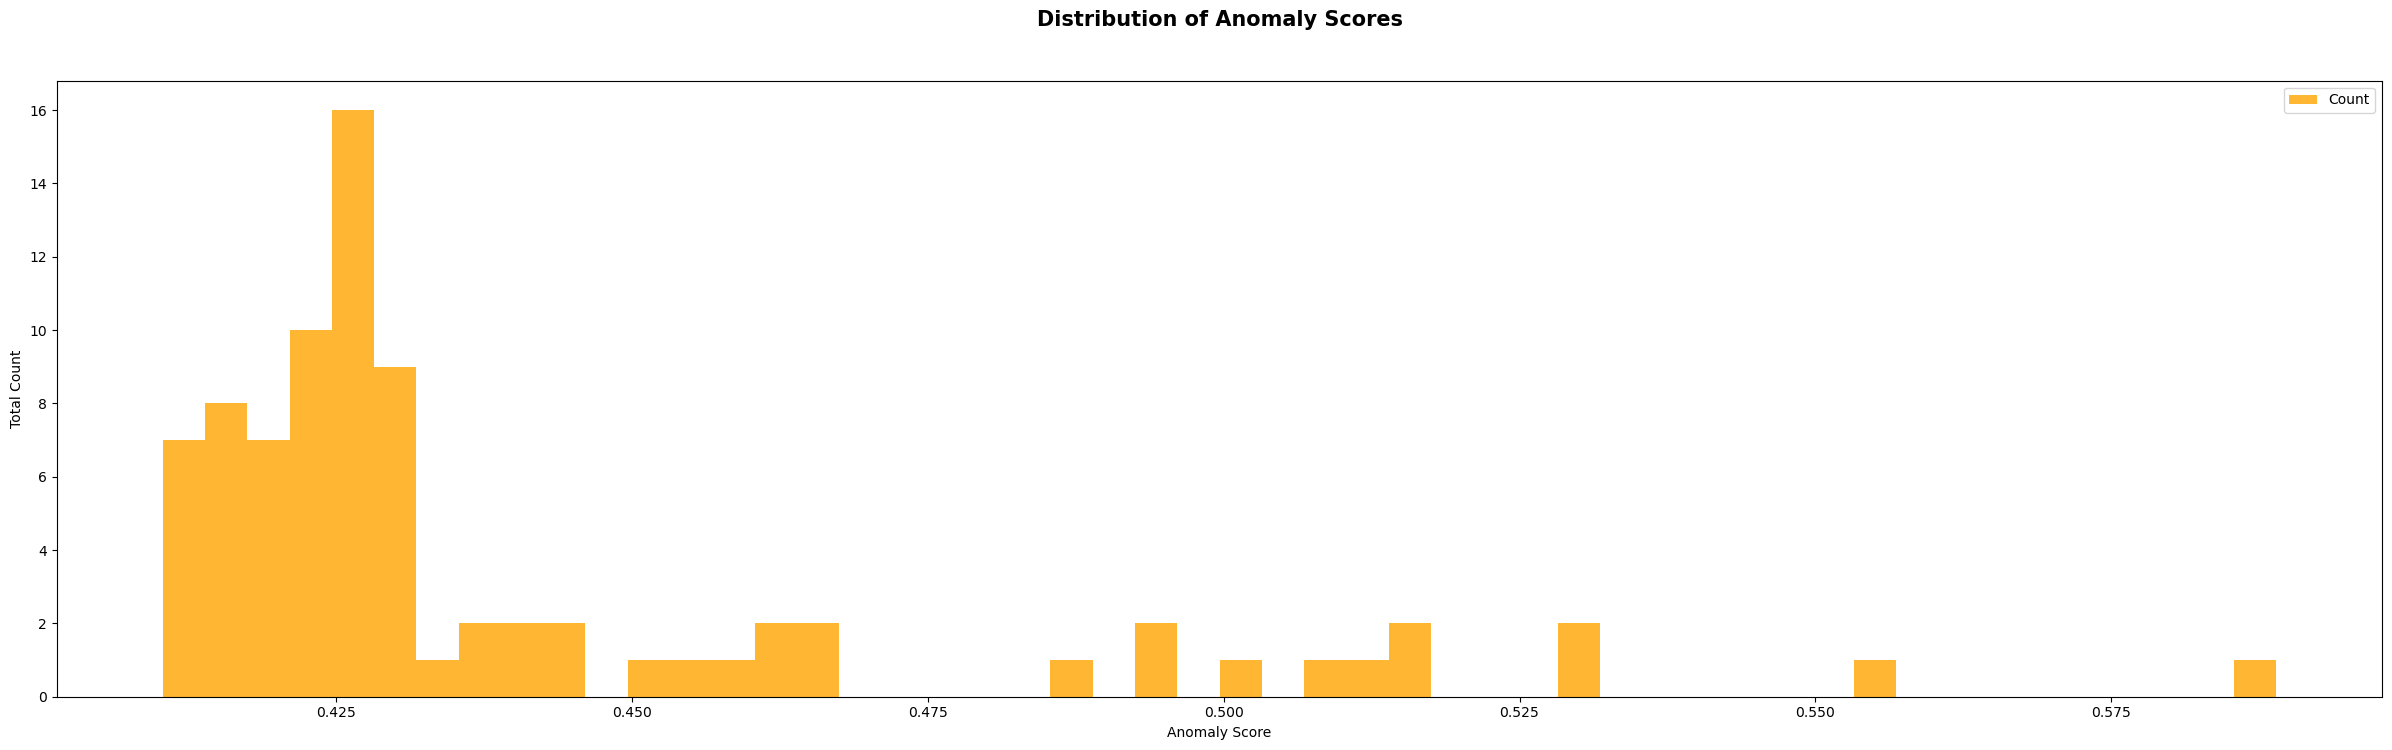

In [81]:
"""This is a histogram of the obtained Anomaly Scores for each user with a right tail end and 
adjustable bin sizes. This visualization helps identify how the distribution of the anomaly scores 
look throughout the modeled data.
X – axis = Anomaly Score, Y-axis = Number of total occurrences """

#Total number of bins can be adjusted to understand the visualization better
total_bins = 50
fig = plt.figure()
#Setting width and height 
fig.set_figwidth(30)
fig.set_figheight(8)
#The data, bins and patches for the histogram
n, bins, patches = plt.hist(normalized_scores, total_bins, color = "orange", alpha = 0.8)
#Setting labels, titles and legends
plt.xlabel('Anomaly Score')
plt.ylabel('Total Count')
plt.title('Distribution of Anomaly Scores\n\n',
          fontweight ="bold",fontsize = 15)
plt.legend(["Count"])
plt.show()

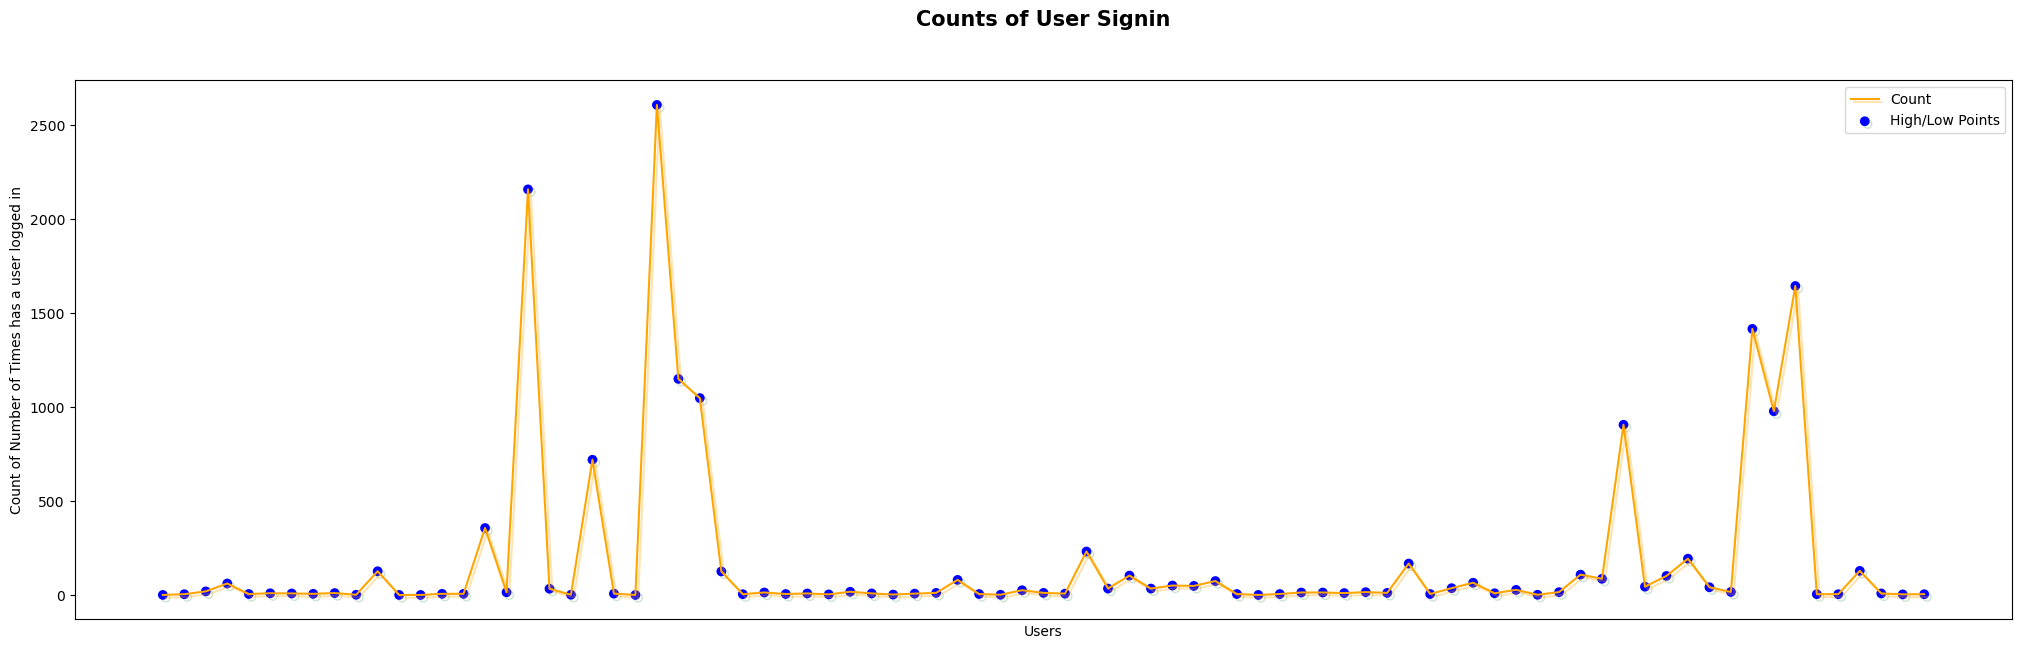

In [86]:
"""The following image shows a line graph for the total number of logins for each user. 
The highest points signify anomalies and are further visualized in another line graph. 
This visualization helps identify how the distribution of the number of logins per user 
look throughout the modeled data. 
X – axis = User, Y-axis = Number of total logins
"""

fig = plt.figure()
#Setting width and height for the figure
fig.set_figwidth(25)
fig.set_figheight(7)
#Graphing a scatter plot and and a line graph to visualize all high and low points
plt.scatter(count_aggregate["{}".format(user_entities[0])], count_aggregate["No. of Login Times"], color = "blue", path_effects=[pe.SimpleLineShadow(shadow_color='g'), pe.Normal()])
plt.plot(count_aggregate["{}".format(user_entities[0])], count_aggregate["No. of Login Times"], color = "orange", path_effects=[pe.SimpleLineShadow(shadow_color='orange'), pe.Normal()])
#Setting labels, title and legend
plt.xlabel('Users')
plt.ylabel('Count of Number of Times has a user logged in')
plt.title('Counts of User Signin\n\n',
          fontweight ="bold", fontsize=15)
plt.xticks([])  
plt.legend(["Count","High/Low Points"])
plt.show()

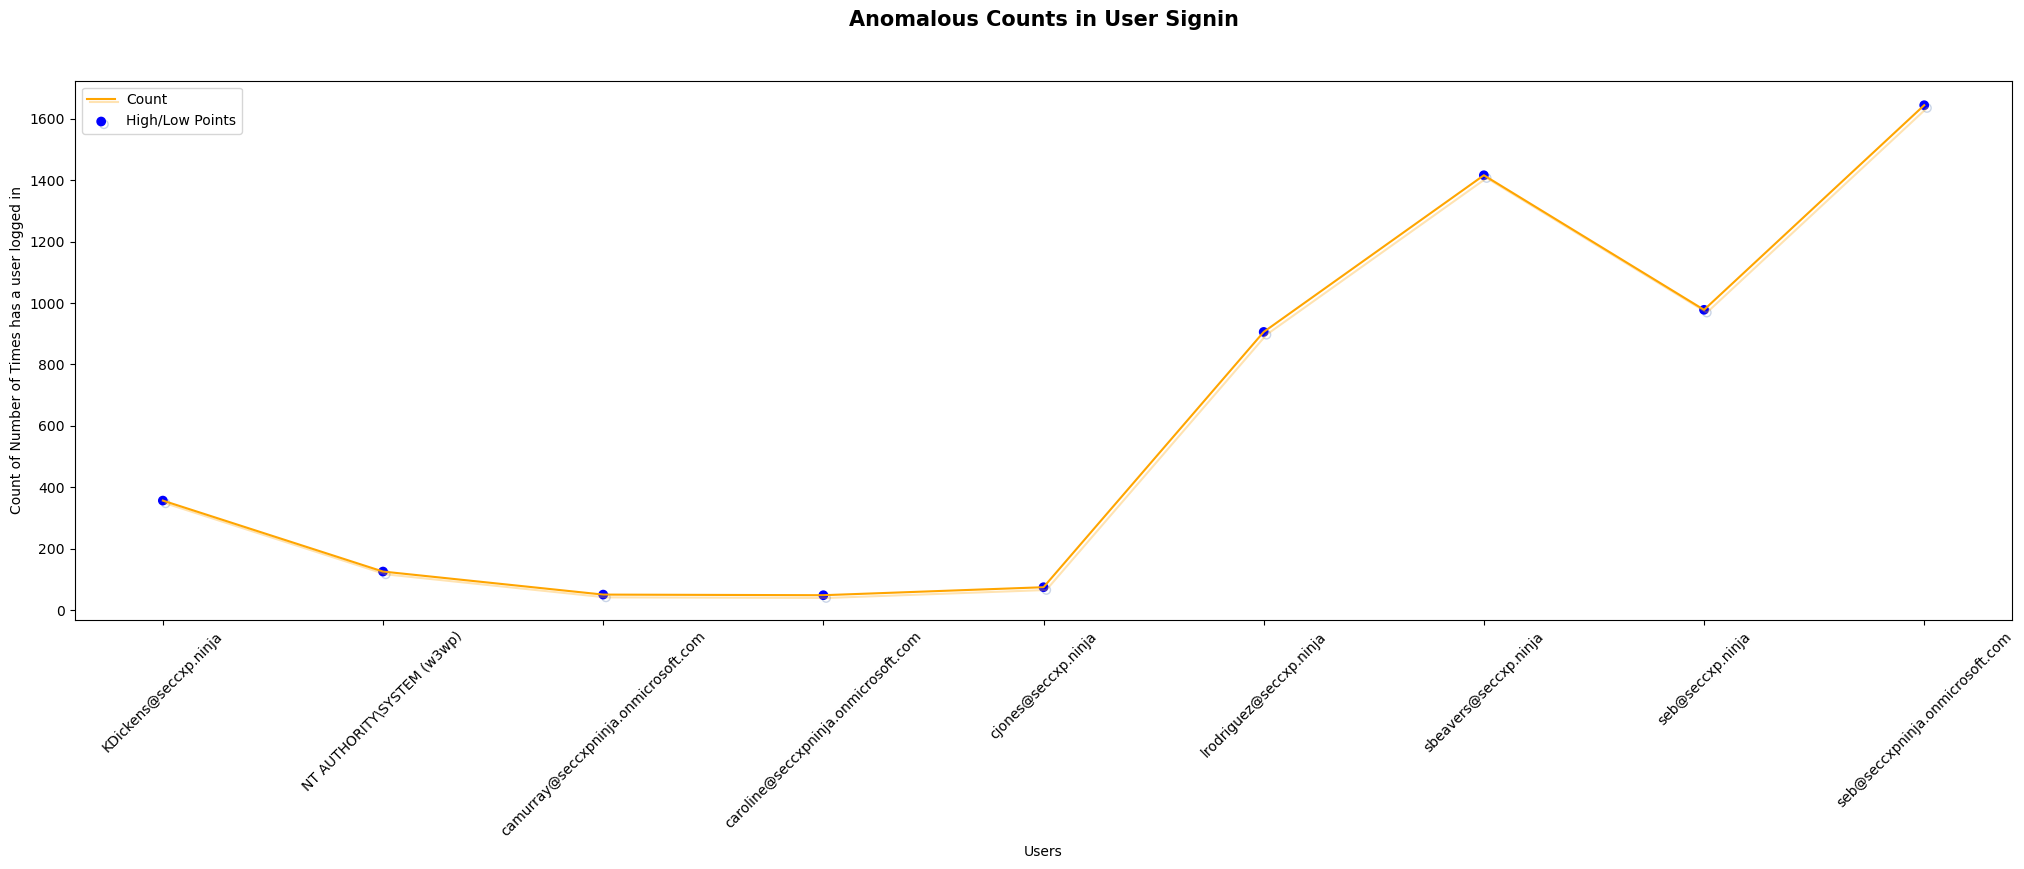

In [88]:
"""The following image is derived the previous one shows a line graph for the total number of 
logins for only the anomalous users. The highest points signify anomalies with the anomalies. 
This visualization helps identify how the distribution of the number of logins per anomalous user 
look throughout the modeled data. 
X – axis = User, Y-axis = Number of total logins
"""

fig = plt.figure()
#Setting width and height for the figure
fig.set_figwidth(25)
fig.set_figheight(7)
#Graphing a scatter plot and and a line graph to visualize all high and low anomalous users
plt.scatter(anomaly_count_model["{}".format(user_entities[0])], anomaly_count_model["No. of Login Times"], color = "blue", path_effects=[pe.SimpleLineShadow(shadow_color='b'), pe.Normal()])
plt.plot(anomaly_count_model["{}".format(user_entities[0])], anomaly_count_model["No. of Login Times"], color = "orange", path_effects=[pe.SimpleLineShadow(shadow_color='orange'), pe.Normal()])
#Setting labels, title and legend
plt.xlabel('Users')
plt.xticks(rotation=45)
plt.ylabel('Count of Number of Times has a user logged in')
plt.title('Anomalous Counts in User Signin\n\n',
          fontweight ="bold", fontsize=15)
plt.legend(["Count", "High/Low Points"])
plt.show()

In [89]:
user_features

['ExternalAccess', 'OfficeWorkload', 'Operation', 'ResultStatus', 'UserType']

<ipython-input-91-85a3ee8ca00e>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


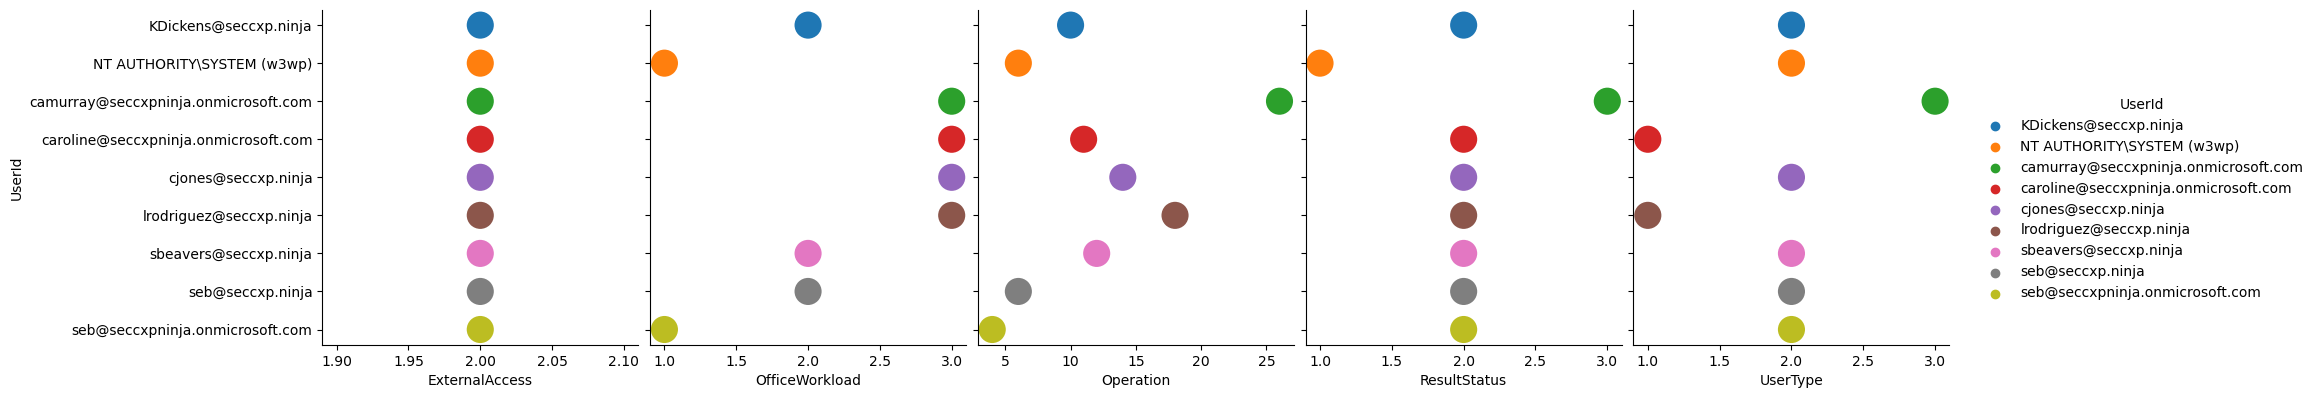

In [91]:
"""
This pairplot shows a relation between all the users and their column counts in relation to 
other users. 

X-axis - Total number of occurences, Y-axis - Anomalous users

"""
g = sns.pairplot(anomaly_count_model, x_vars = user_features , y_vars = user_entities[0], hue=user_entities[0], plot_kws={"s": 450},height = 4)
fig.show()

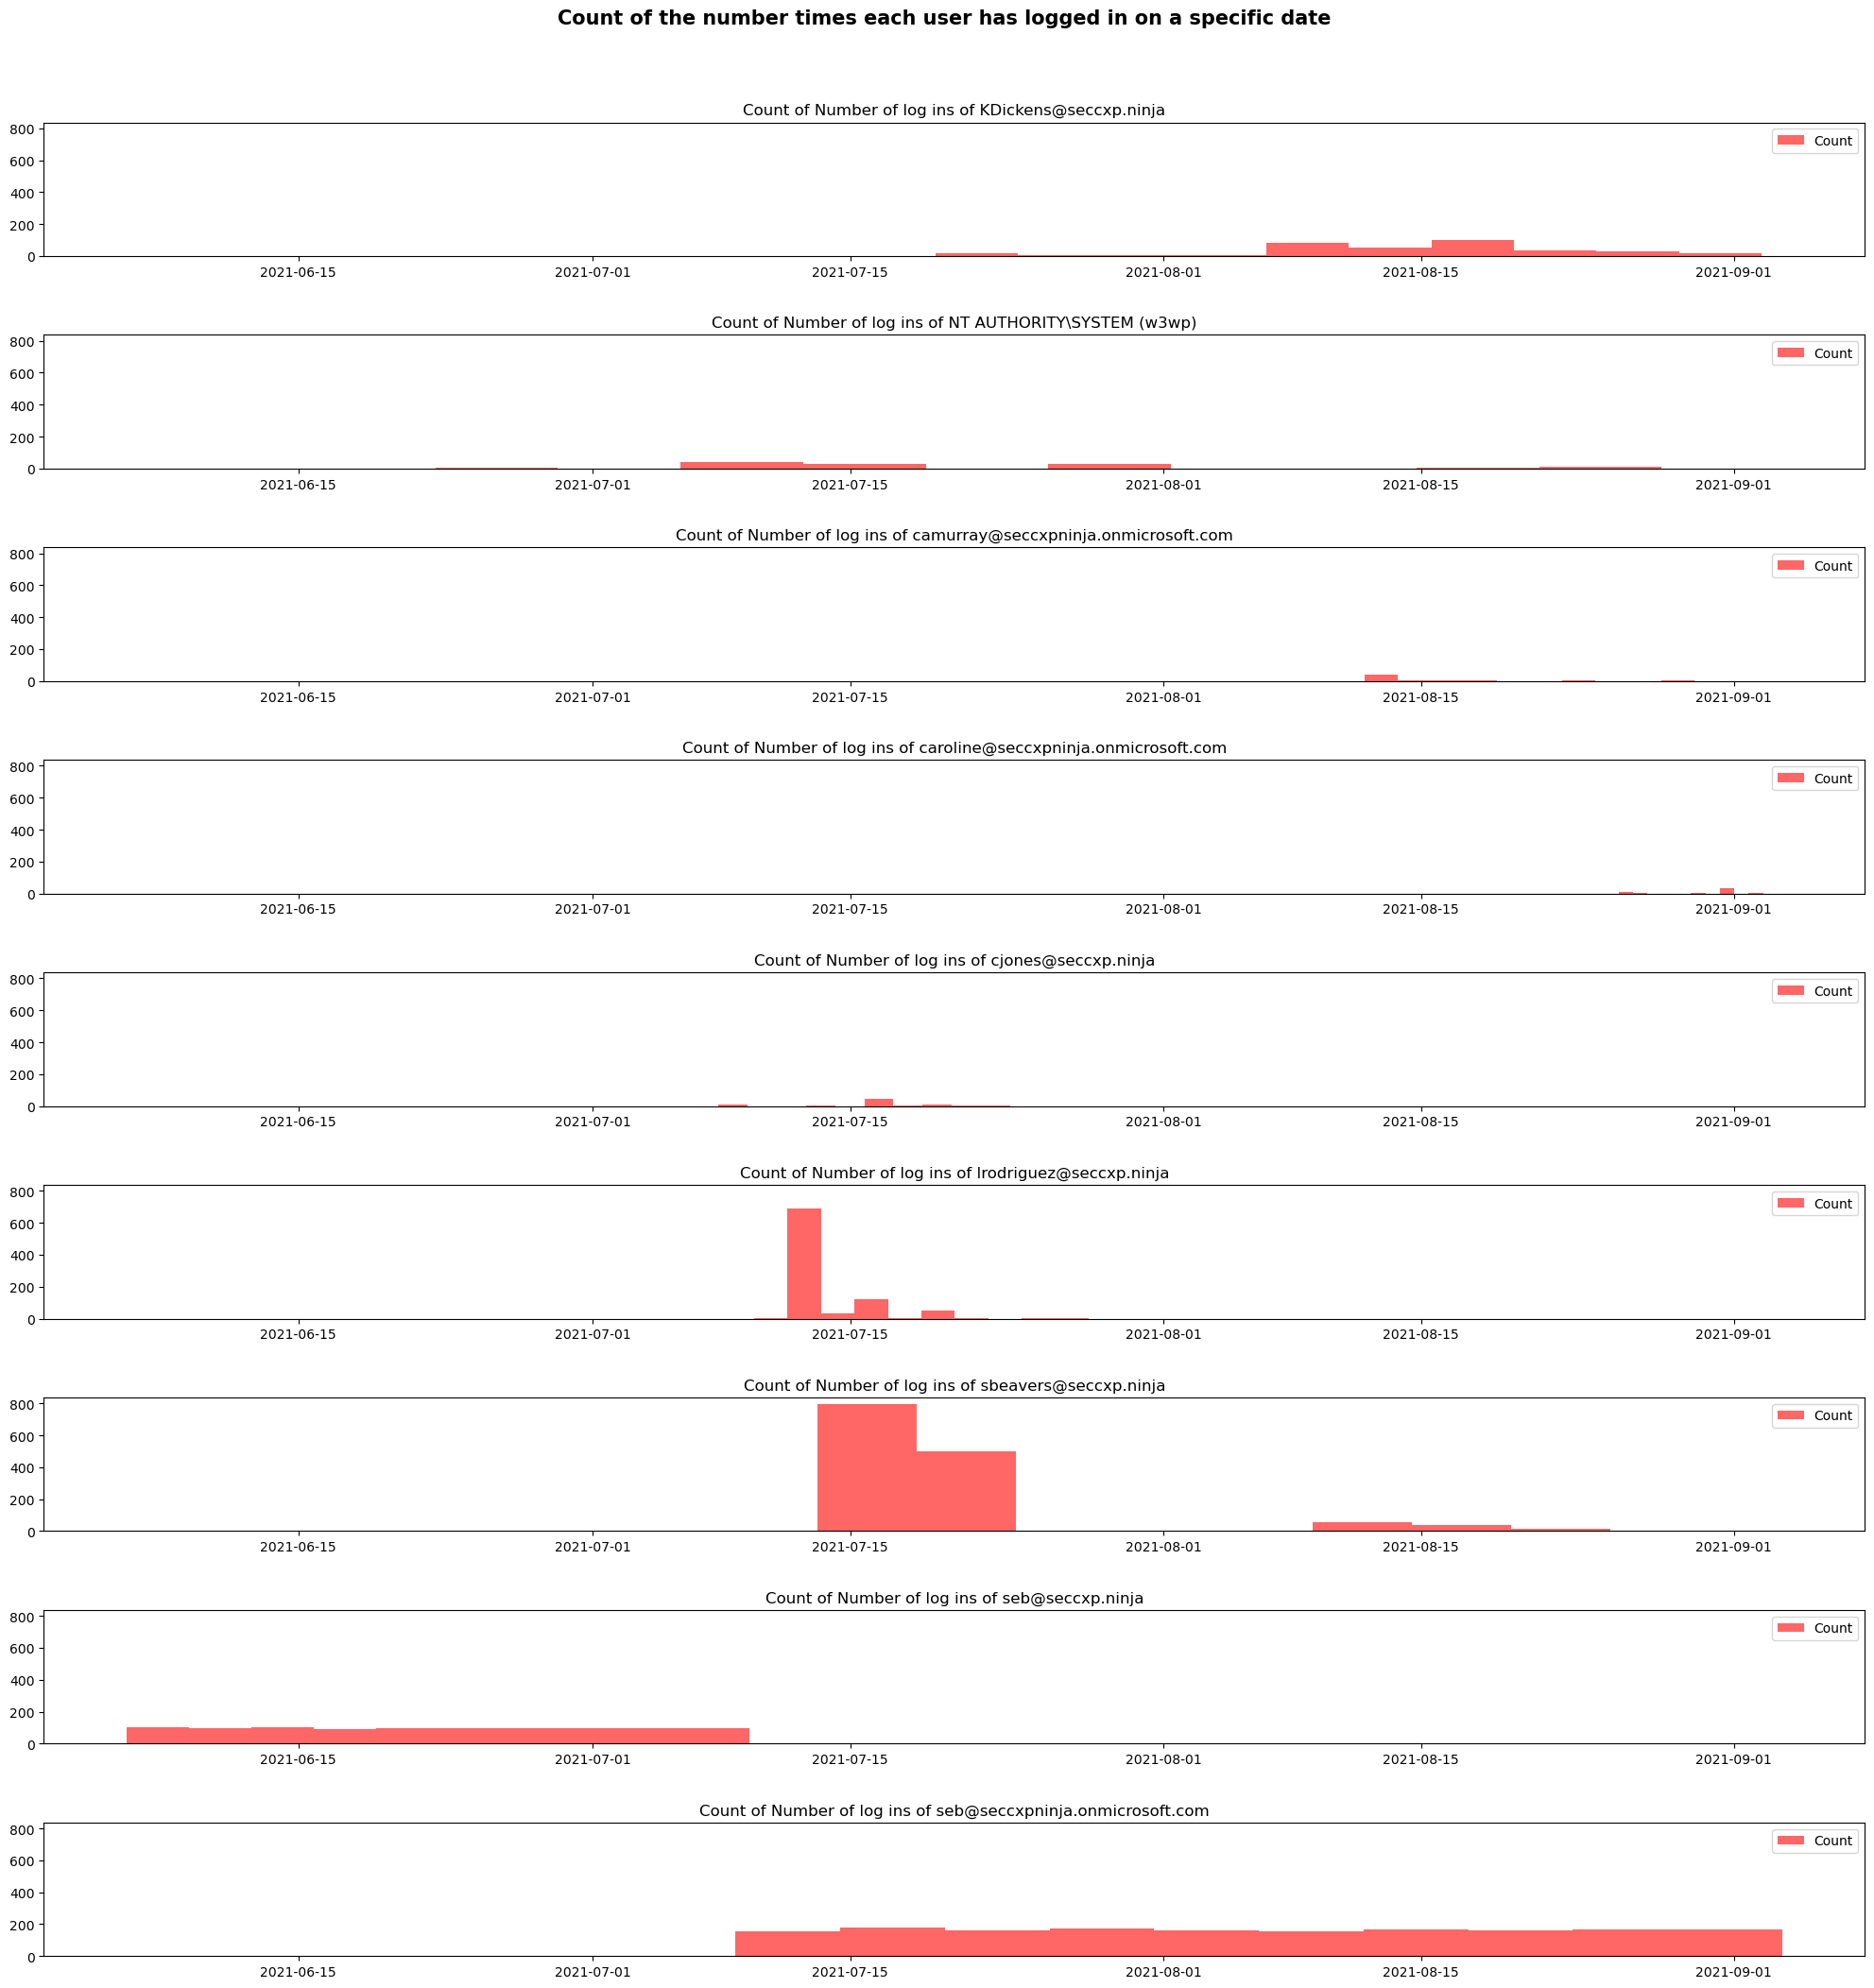

In [95]:
"""
The following visual shows a series of bar graphs for each anomalous user visualizing the distribution of their total logins over time. This visualization shows how often a user has logged in and if their logins are consistent or unanticipated (suspicious)
X – axis = Dates (YYYY-MM-DD), Y-axis = Number of total logins

"""
fig, ax = plt.subplots(len(anomaly_data_model[user_entities[0]]), sharey=True, sharex = True)
#Setting the width, height and title
fig.set_figwidth(20)
fig.set_figheight(20)
fig.tight_layout(h_pad=5)
count = 0
fig.suptitle("Count of the number times each user has logged in on a specific date", fontweight ="bold", fontsize=15, y= 1.05)

#Creating a time series graph for each user
for i in anomaly_data_model["Login Times"]:
    x = list(i)
    ax[count].hist(x, alpha = 0.6, facecolor="red",histtype = 'stepfilled')
    ax[count].title.set_text("Count of Number of log ins of {}".format(anomaly_data_model.loc[count, user_entities[0]])) 
    ax[count].legend(["Count"])
    ax[count].tick_params(labelbottom=True)
    count+=1


plt.show()

In [97]:
#Creating a transposed matrix to create a treemap
transposed = anomaly_count_model.transpose()
transposed.set_axis(anomaly_count_model[user_entities[0]], axis = 'columns',inplace=True)
transposed.drop(["Anomalies", "Normalized Anomaly Score",user_entities[0]],inplace = True)
label = list(transposed.index)
transposed

UserId,KDickens@seccxp.ninja,NT AUTHORITY\SYSTEM (w3wp),camurray@seccxpninja.onmicrosoft.com,caroline@seccxpninja.onmicrosoft.com,cjones@seccxp.ninja,lrodriguez@seccxp.ninja,sbeavers@seccxp.ninja,seb@seccxp.ninja,seb@seccxpninja.onmicrosoft.com
No. of Login Times,357,126,51,49,75,906,1416,978,1644
ExternalAccess,2,2,2,2,2,2,2,2,2
OfficeWorkload,2,1,3,3,3,3,2,2,1
Operation,10,6,26,11,14,18,12,6,4
ResultStatus,2,1,3,2,2,2,2,2,2
UserType,2,2,3,1,2,1,2,2,2


Do you want to include Number of Login times in the treemap? Type 'y' or 'n'n


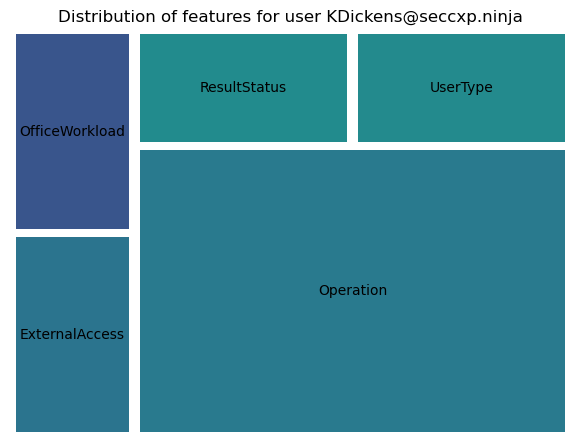

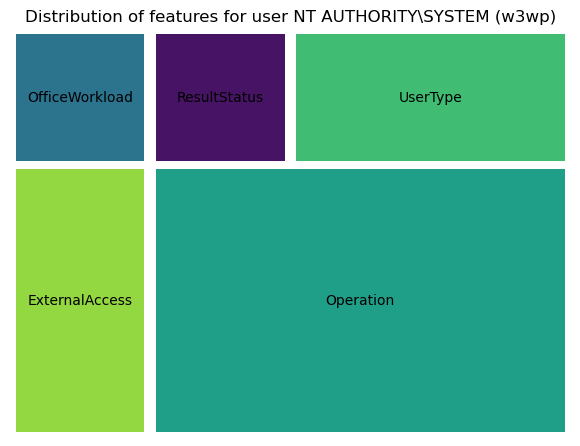

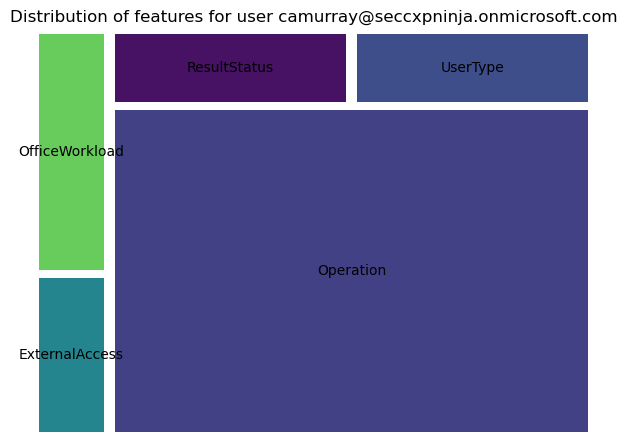

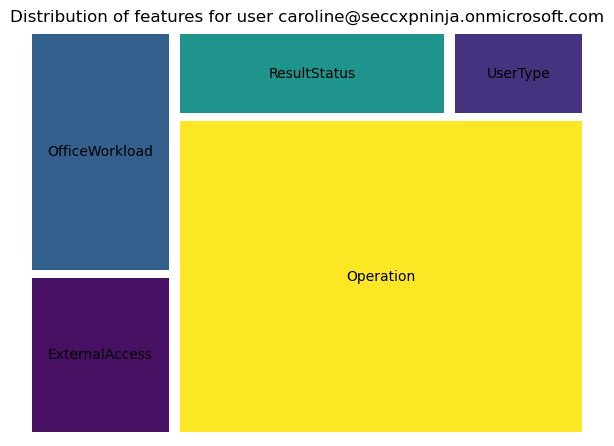

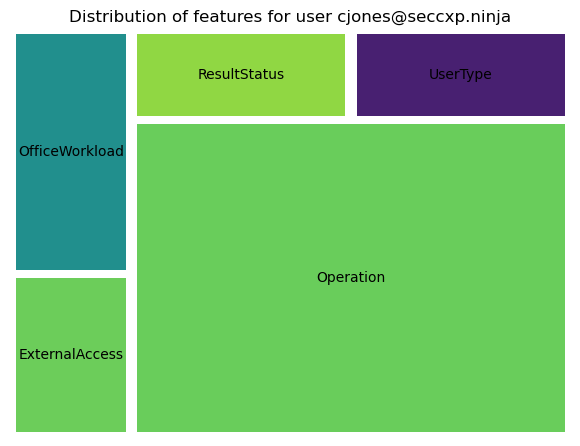

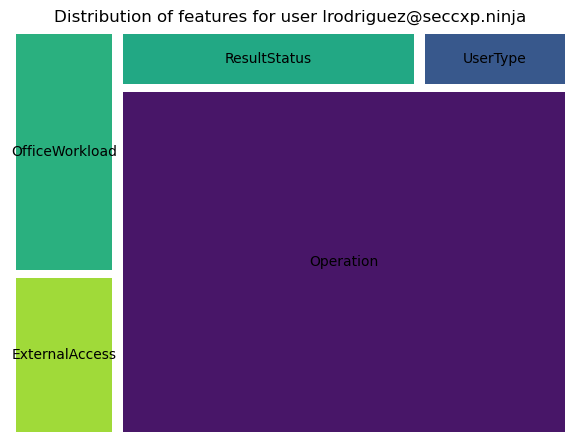

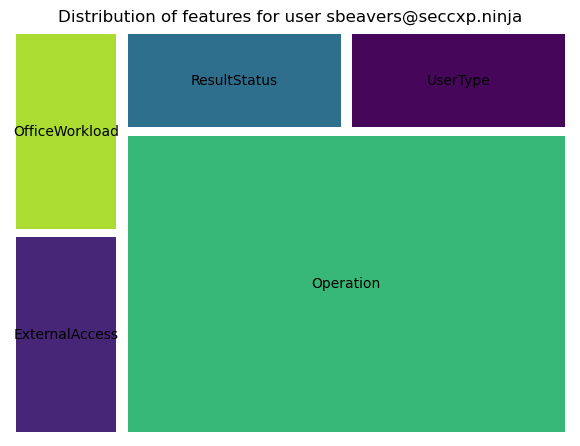

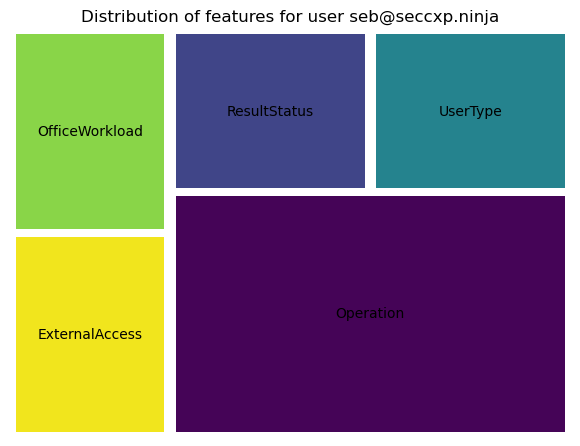

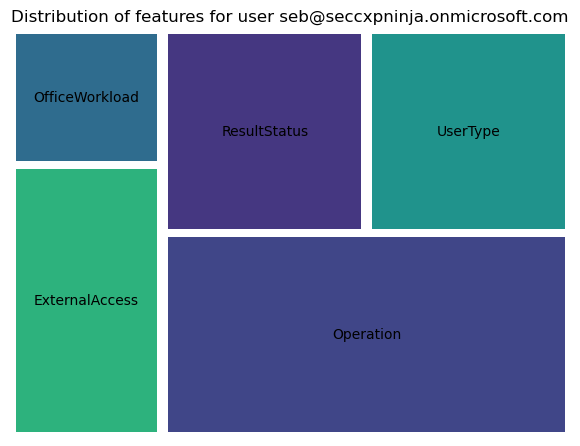

In [102]:
"""
This treemap for distribution of features for each user. We also give the user an option 
if they want to include the 

"""



while True:
    login = input("Do you want to include Number of Login times in the treemap? Type 'y' or 'n'")
    if (login.lower() == "n") or (login.lower() == "no"):
        if 'No. of Login Times' in label:
            label.remove('No. of Login Times')
        break
    elif (login.lower() == "y") or (login.lower() == "yes"):
        break        
    else:
        print("Please enter a valid response.")
        continue
        
for i in anomaly_count_model[user_entities[0]]:
    sizes = list(transposed[i])
    plt.title("Distribution of features for user {}".format(i))
    if (login.lower() == "n") or (login.lower() == "no"):
        sizes = sizes[1:] 
    squarify.plot(sizes=sizes, label=label, pad = True)
    plt.tight_layout()
    plt.axis('off')
    plt.show()